In [20]:
### Function Imports
from OptionsFunctions import set_price_and_strike, daily_returns, compute_sigma, black_scholes, hedge_pos_and_rets, calculate_hedged_unhedged, plot_hedged_returns
import pandas as pd


In [21]:
### Call Function to Get Most Recent Stock Price and Set Strike
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
pair = 'USDEUR=X'
start_date = '2023-07-01'

forex_data, S_0, K = set_price_and_strike(pair, start_date, option_type = 'call')
print(forex_data)
print('The Spot Price is:', round(S_0, 4))
print('The pre-determined Strike Price is:', round(K, 4))


[*********************100%%**********************]  1 of 1 completed

          Date  USDEUR=X
0   2023-07-03   0.91680
1   2023-07-04   0.91633
2   2023-07-05   0.91870
3   2023-07-06   0.92110
4   2023-07-07   0.91822
..         ...       ...
257 2024-06-26   0.93374
258 2024-06-27   0.93632
259 2024-06-28   0.93384
260 2024-07-01   0.93151
261 2024-07-02   0.93140

[262 rows x 2 columns]
The Spot Price is: 0.9314
The pre-determined Strike Price is: 0.95


In [23]:
### Function Call to Compute Daily Returns
daily_rets = daily_returns(forex_data)
print(daily_rets)


          Date  USDEUR=X
0   2023-07-04 -0.000513
1   2023-07-05  0.002586
2   2023-07-06  0.002612
3   2023-07-07 -0.003127
4   2023-07-10 -0.007210
..         ...       ...
256 2024-06-26  0.002157
257 2024-06-27  0.002763
258 2024-06-28 -0.002649
259 2024-07-01 -0.002495
260 2024-07-02 -0.000118

[261 rows x 2 columns]


In [24]:
### Return Computed Sigma Value
sigma = compute_sigma(daily_rets)
print('The sigma value was computed to be:', round(sigma, 5))


The sigma value was computed to be: 0.06188


In [25]:
### Call Function to Compute Option Premium and Greeks
r = 0.02
r_f = 0.01
T = 1
option_type = 'call'
option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type)

# Print and explain values
print(f"Option Type: {option_type}")
print(f"Option Price: {option_price:.4f}")
print(f"Delta: {delta:.4f} - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)")
print(f"Gamma: {gamma:.4f} - Gamma measures the rate of change of Delta with respect to changes in the underlying price.")
print(f"Theta: {theta:.4f} - Theta measures the sensitivity of the option's price to the passage of time.")
print(f"Rho: {rho:.4f} - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.")
print(f"Vega: {vega:.4f} - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.")
print(f"Probability ITM (Call): {prob_ITM_call:.4f} - Probability the call option finishes In The Money.")
print(f"Probability ITM (Put): {prob_ITM_put:.4f} - Probability the put option finishes In The Money.")
print(f"Probability of Exercise (Call): {prob_exercise_call:.4f} - Probability the call option will be exercised.")
print(f"Probability of Exercise (Put): {prob_exercise_put:.4f} - Probability the put option will be exercised.")


Option Type: call
Option Price: 0.0186
Delta: 0.4448 - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)
Gamma: 6.7976 - Gamma measures the rate of change of Delta with respect to changes in the underlying price.
Theta: -0.0151 - Theta measures the sensitivity of the option's price to the passage of time.
Rho: 0.3957 - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.
Vega: 0.3649 - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.
Probability ITM (Call): 0.4493 - Probability the call option finishes In The Money.
Probability ITM (Put): 0.5507 - Probability the put option finishes In The Money.
Probability of Exercise (Call): 0.4249 - Probability the call option will be exercised.
Probability of Exercise (Put): 0.5751 - Probability the put option will be exercised.


In [26]:
### Call Hedged Rets Function
long_pos = 1000  # units of currency pair (not dollars)
hedge_pos, hedged_rets = hedge_pos_and_rets(daily_rets, delta, long_pos)
print('The computed hedge position is:', round(hedge_pos, 4))
print("Hedged Returns:")
print(hedged_rets.head())


The computed hedge position is: -444.8122
Hedged Returns:
     USDEUR=X
0 -444.812690
1 -444.809591
2 -444.809565
3 -444.815305
4 -444.819387


In [27]:
### Call Calculated Hedged/Unhedged Returns Function
hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)
print("Hedged Cumulative Returns:")
print(hedged_cumulative_rets.tail())
print("Unhedged Cumulative Returns:")
print(unhedged_cumulative_rets.tail())


Hedged Cumulative Returns:
Date
2024-06-26    1010.709054
2024-06-27    1012.259504
2024-06-28    1010.770950
2024-07-01    1009.370792
2024-07-02    1009.304634
Name: USDEUR=X, dtype: float64
Unhedged Cumulative Returns:
Date
2024-06-26    1018.477309
2024-06-27    1021.291431
2024-06-28    1018.586338
2024-07-01    1016.044883
2024-07-02    1015.924933
Name: USDEUR=X, dtype: float64


In [28]:
### Compute Hedged Returns for All Pairs and Filter to find most Profitable
hedge_ratios_df = pd.DataFrame(columns = ['Pair', 'Option Type', 'Option Premium', 'Delta', 'Long Position', 'Short Position', 'Hedged Returns', 'Unhedged Returns'])

for pair in all_forex_pairs:
    try:
        # Assuming the functions 'set_price_and_strike', 'daily_returns', 'black_scholes', 'hedge_position', and 'calculate_hedged_unhedged' are defined elsewhere
        forex_data, S_0, K = set_price_and_strike(pair, start_date, option_type = 'call')
        daily_rets = daily_returns(forex_data)
        option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type = 'call')
        hedge_pos, hedged_rets = hedge_pos_and_rets(daily_rets, delta, long_pos)
        hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)

        new_row = pd.DataFrame({
            'Pair': [pair],
            'Option Type': [option_type],
            'Option Premium': [option_price],
            'Delta': [delta],
            'Long Position': [long_pos],
            'Short Position': [hedge_pos],
            'Hedged Returns': [hedged_cumulative_rets.iloc[-1] if not hedged_cumulative_rets.empty else None],
            'Unhedged Returns': [unhedged_cumulative_rets.iloc[-1] if not unhedged_cumulative_rets.empty else None]
        })

        hedge_ratios_df = pd.concat([hedge_ratios_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Error computing hedge ratio for {pair}: {e}")

#print(hedge_ratios_df.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [29]:
### Filter for Most Profitable Hedged Pairing
# Sort the DataFrame by the 'Hedged Returns' column in descending order
most_profit_hedged = hedge_ratios_df.sort_values(by = 'Hedged Returns', ascending = False).head(1)
#print(most_profit_hedged)

### Display Results
high_pair = most_profit_hedged.iloc[0]['Pair']
option_type = most_profit_hedged.iloc[0]['Option Type']
high_option_premium = most_profit_hedged.iloc[0]['Option Premium']
high_long_position = most_profit_hedged.iloc[0]['Long Position']
high_short_position = most_profit_hedged.iloc[0]['Short Position']
high_hedged_returns = most_profit_hedged.iloc[0]['Hedged Returns']
high_unhedged_returns = most_profit_hedged.iloc[0]['Unhedged Returns']

print(f"Most Profitable Pairing: {high_pair}")
print(f"Option Type: {option_type}")
print(f"Option Premium: {high_option_premium:.6f}")
print(f"Long Position: {high_long_position}")
print(f"Short Position: {high_short_position:.6f}")
print("\nReturns:")
print(f"Hedged Returns: {high_hedged_returns:.6f}")
print(f"Unhedged Returns: {high_unhedged_returns:.6f}")


Most Profitable Pairing: USDJPY=X
Option Type: call
Option Premium: 3.230707
Long Position: 1000
Short Position: -444.812178

Returns:
Hedged Returns: 1065.560792
Unhedged Returns: 1119.336906


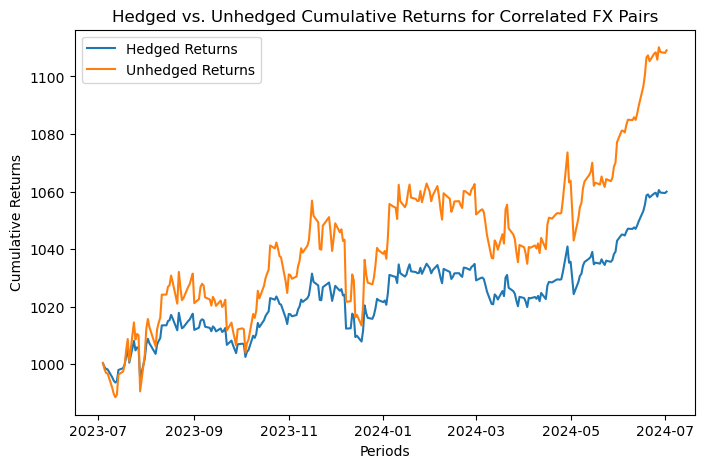

In [33]:
### Plot Hedged vs. Unhedged Returns
plot_hedged_returns(hedged_cumulative_rets, unhedged_cumulative_rets)
